# EXPLORATION 7 : 영화리뷰 텍스트 감성분석하기

## 준비한 데이터
- 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc) 데이터셋
- Pre-trained [한국어 Word2Vec 임베딩](https://github.com/Kyubyong/wordvectors)

## 1. 데이터 준비 및 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 파일 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train data 개수: {}, test data 개수: {}".format(len(train_data), len(test_data)))  # 데이터 개수 확인
train_data.head()  # 데이터 출력

train data 개수: 150000, test data 개수: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

# 데이터 로더 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    train_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    test_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    test_data = test_data.dropna(how = 'any')  # 결측치 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  # 단어 빈도순으로 (10000-4)개 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 앞부분 4개 추가
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {단어:인덱스} 단어사전 생성
    
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터 로더 실행하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

index_to_word = {index:word for word, index in word_to_index.items()}  # {인덱스:단어} 딕셔너리 생성

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


train data 개수: 145791, test data 개수: 48995


In [3]:
# 인코딩 & 디코딩 함수 정의
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# decode된 문장과 라벨을 비교하여 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 192, 2]
재 <UNK>
라벨:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[627, 2, 2, 425, 171, 1464, 661, 1592, 665, 46, 2, 4, 61, 2167, 118, 718]
<UNK> <UNK> 세 부터 초등 학교 학년 생 인 <UNK> 영화 ㅋㅋㅋ 별반 개 아까움
라벨:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
라벨:  0
[232, 1344, 132, 5, 392, 705, 2, 2, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 2, 37]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
라벨:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 몇 안 되 영화
라벨:  1
[57, 612

## 3. 데이터 분포 분석 및 패딩

In [4]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# padding으로 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


In [6]:
# 훈련용 데이터셋 145791건 중 40000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(40000, 36)
(40000,)
(105791, 36)
(105791,)


## 4. 모델별 설계, 학습, 평가, 시각화 해보기
- LSTM
- 1-D Convolution Neural Network(1-D CNN)
- GlobalMaxPooling1D()

### (1) LSTM 모델
Recurrent Neural Netowrk(RNN)은 텍스트 데이터를 다루는데 주로 사용되는 딥러닝 모델이다. RNN은 시퀀스(Sequence) 형태의 데이터 처리에 최적인 모델로, 이전 시점의 모든 입력의 정보가 현재 상태에 반영되는 state machine으로 설계되었다. LSTM은 RNN 중에서도 가장 널리 쓰이는 모델이다.

### 모델 설계

In [7]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
lstm_model = keras.Sequential(name="LSTM")
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
lstm_model.add(keras.layers.Dense(8, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 평가

In [8]:
# model 학습
lstm_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = lstm_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 9s 30ms/step - loss: 0.6218 - accuracy: 0.6319 - val_loss: 0.3893 - val_accuracy: 0.8362
Epoch 2/5
207/207 [==============================] - 5s 24ms/step - loss: 0.3531 - accuracy: 0.8552 - val_loss: 0.3576 - val_accuracy: 0.8418
Epoch 3/5
207/207 [==============================] - 5s 24ms/step - loss: 0.3092 - accuracy: 0.8704 - val_loss: 0.3553 - val_accuracy: 0.8443
Epoch 4/5
207/207 [==============================] - 5s 23ms/step - loss: 0.2842 - accuracy: 0.8819 - val_loss: 0.3594 - val_accuracy: 0.8449
Epoch 5/5
207/207 [==============================] - 5s 23ms/step - loss: 0.2624 - accuracy: 0.8888 - val_loss: 0.3721 - val_accuracy: 0.8437


In [9]:
# test set으로 model 평가
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
print(lstm_results)

1532/1532 - 4s - loss: 0.3741 - accuracy: 0.8422
[0.3740885555744171, 0.8422083854675293]


### 시각화 해보기

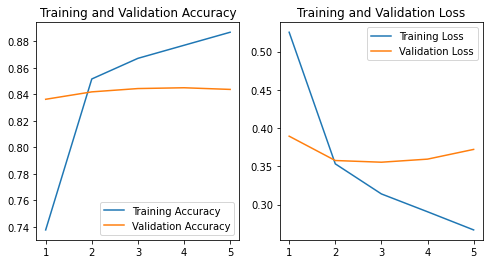

In [10]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### (2) 1-D CNN 모델
텍스트 처리에 1-D Convolutional Neural Network(1-D CNN)을 사용할 수도 있다. 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 필터로 스캐닝하면서 필터 크기만큼의 단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식이다.

### 모델 설계

In [11]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(16, 3, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(16, 3, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          9616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9       

### 모델 학습 및 평가

In [12]:
# model 학습
CNN_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = CNN_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 11s 38ms/step - loss: 0.5753 - accuracy: 0.7003 - val_loss: 0.3590 - val_accuracy: 0.8403
Epoch 2/5
207/207 [==============================] - 5s 22ms/step - loss: 0.3190 - accuracy: 0.8653 - val_loss: 0.3522 - val_accuracy: 0.8445
Epoch 3/5
207/207 [==============================] - 5s 22ms/step - loss: 0.2599 - accuracy: 0.8963 - val_loss: 0.3631 - val_accuracy: 0.8433
Epoch 4/5
207/207 [==============================] - 5s 23ms/step - loss: 0.2028 - accuracy: 0.9256 - val_loss: 0.3971 - val_accuracy: 0.8387
Epoch 5/5
207/207 [==============================] - 5s 22ms/step - loss: 0.1523 - accuracy: 0.9478 - val_loss: 0.4533 - val_accuracy: 0.8334


In [13]:
# test set으로 model 평가
results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 4s - loss: 0.4589 - accuracy: 0.8320
[0.4589489698410034, 0.8319624662399292]


### 시각화 해보기

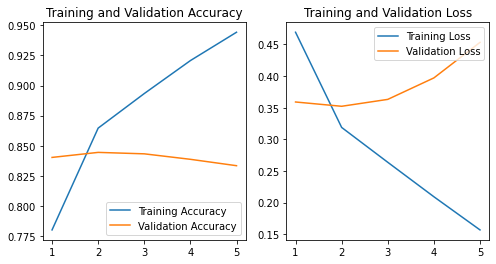

In [14]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### (3) GlobalMaxPooling1D
GlobalMaxPooling1D() 레이어 하나만 사용하는 방법은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이다.

### 모델 설계

In [15]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
MaxPooling1D_model = keras.Sequential(name="GlabalMaxPooling1D")
MaxPooling1D_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
MaxPooling1D_model.add(keras.layers.GlobalMaxPooling1D())
MaxPooling1D_model.add(keras.layers.Dense(8, activation='relu'))
MaxPooling1D_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

MaxPooling1D_model.summary()

Model: "GlabalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 평가

In [16]:
# model 학습
MaxPooling1D_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = MaxPooling1D_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 5s 21ms/step - loss: 0.5826 - accuracy: 0.7369 - val_loss: 0.3623 - val_accuracy: 0.8402
Epoch 2/5
207/207 [==============================] - 4s 20ms/step - loss: 0.3262 - accuracy: 0.8615 - val_loss: 0.3467 - val_accuracy: 0.8479
Epoch 3/5
207/207 [==============================] - 4s 20ms/step - loss: 0.2713 - accuracy: 0.8918 - val_loss: 0.3523 - val_accuracy: 0.8486
Epoch 4/5
207/207 [==============================] - 4s 20ms/step - loss: 0.2264 - accuracy: 0.9131 - val_loss: 0.3667 - val_accuracy: 0.8473
Epoch 5/5
207/207 [==============================] - 4s 20ms/step - loss: 0.1845 - accuracy: 0.9345 - val_loss: 0.3889 - val_accuracy: 0.8460


In [17]:
# test set으로 model 평가
results = MaxPooling1D_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3985 - accuracy: 0.8399
[0.3984573185443878, 0.8399428725242615]


### 시각화 해보기

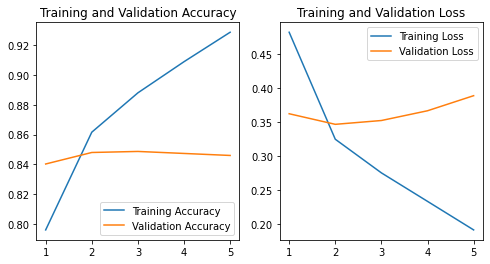

In [18]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 모델 비교

In [19]:
print("LSTM 모델의 성능")
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
print("CNN 모델의 성능")
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print("MaxPooling1D 모델의 성능")
MaxPooling1D_results = MaxPooling1D_model.evaluate(X_test,  y_test, verbose=2)

LSTM 모델의 성능
1532/1532 - 4s - loss: 0.3741 - accuracy: 0.8422
CNN 모델의 성능
1532/1532 - 3s - loss: 0.4589 - accuracy: 0.8320
MaxPooling1D 모델의 성능
1532/1532 - 2s - loss: 0.3985 - accuracy: 0.8399


accuracy를 비교해보면 LSTM 모델이 가장 높고  
loss값도 LSTM 모델이 가장 낮기 때문에  
가장 우수한 LSTM 모델을 사용하도록 하겠다.

## 5. 학습된 Embedding 레이어 분석

In [20]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [21]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("재미")

[('가치', 0.7946121692657471),
 ('케', 0.7845090627670288),
 ('볼수록', 0.7748836278915405),
 ('긴장감', 0.7711963653564453),
 ('공감', 0.7693910002708435),
 ('영화광', 0.7681675553321838),
 ('의리', 0.748965322971344),
 ('퍼지', 0.7471268177032471),
 ('기억나', 0.736553430557251),
 ('너무나', 0.735376238822937)]

## 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [23]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

#이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
vocab_size = len(index_to_word)    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [24]:
from tensorflow.keras.initializers import Constant

# model 설계 
lstmk_model = keras.Sequential(name="LSTM-Kor")
lstmk_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
lstmk_model.add(keras.layers.LSTM(128)) #LSTM state 벡터의 차원수
lstmk_model.add(keras.layers.Dense(8, activation='relu'))
lstmk_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstmk_model.summary()

Model: "LSTM-Kor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 오버피팅 없애기
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
     # validataion set의 loss를 monitoring 한다
     # performance measuer(어떤 성능을 모니터링 할것인가?) 를 최소화 시켜야하는 training이다.
     # verbose=1 : 언제 keras에서 training을 멈추었는지 화면에 출력
     # patience : 성능이 더이상 증가하지 않은 epoch를 몇 번이나 허용할 것인가?
    
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
 #EarlyStopping 객체에 의해 training이 중지되었을 때, validation performance가 가장 높았던 모델 선정

In [26]:
# 모델 학습 시작
lstmk_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10

history = lstmk_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/10
414/414 [==============================] - 14s 29ms/step - loss: 0.6488 - accuracy: 0.5728 - val_loss: 0.3875 - val_accuracy: 0.8256
Epoch 2/10
414/414 [==============================] - 10s 25ms/step - loss: 0.3532 - accuracy: 0.8450 - val_loss: 0.3470 - val_accuracy: 0.8478
Epoch 3/10
414/414 [==============================] - 10s 25ms/step - loss: 0.2902 - accuracy: 0.8765 - val_loss: 0.3349 - val_accuracy: 0.8556
Epoch 4/10
414/414 [==============================] - 10s 25ms/step - loss: 0.2546 - accuracy: 0.8949 - val_loss: 0.3693 - val_accuracy: 0.8494
Epoch 5/10
414/414 [==============================] - 10s 25ms/step - loss: 0.2245 - accuracy: 0.9089 - val_loss: 0.3538 - val_accuracy: 0.8551
Epoch 6/10
414/414 [==============================] - 10s 25ms/step - loss: 0.1869 - accuracy: 0.9270 - val_loss: 0.3759 - val_accuracy: 0.8544
Epoch 00006: early stopping


In [27]:
# 학습 끝난 모델을 테스트셋으로 평가하기
lstmk_results = lstmk_model.evaluate(X_test,  y_test, verbose=2)

print(lstmk_results)

1532/1532 - 6s - loss: 0.3801 - accuracy: 0.8506
[0.3801111578941345, 0.8505561947822571]


# 프로젝트 결과

### 결과
- LSTM, 1-D CNN, GlobalMaxPooling1D 세가지 모델을 구현한 후 학습결과를 비교해보았고 가장 높은 성능을 가진 LSTM 모델을 선택하여 한국어 Word2Vec에 적용하였다.
- 언어의 의미와 유사도를 고려하여 언어를 벡터로 매핑하는 방식인 Word2Vec를 활용하여 학습하였다.
- 오버피팅을 억제하는 EarlyStopping와 그것으로 인해 멈추었을 때 validation performance가 가장 높았던 모델을 선정해주는 ModelCheckpoint을 이용하여 학습하였다.
- 사전학습된 한국어 Word2Vec 임베딩 활용하여 정확도를 85% 이상으로 개선하였다.

### 느낀점
- 작사가 만들기 노드에서 RNN의 개념에 대해 공부해야겠다고 생각했는데 이번 노드를 통해 RNN의 개념을 더 잘 이해하게 되어서 좋았다.
- 처음에 gensim 버전문제 때문에 에러가 난 줄 모르고 해결책을 찾는것에 시간을 많이 투자했는데 버전을 낮춰보니 바로 되어서 다행이었다. 프로젝트 할 때 패키지 버전이 중요하다는 말을 처음으로 이해하게 되었다.
- 정확도 85%로 개선하기 위해 다양한 시도를 하다가 EarlyStopping을 이용해보니 오버피팅을 방지할 수 있어서 확실히 좋은 것 같다. 앞으로도 계속 이용할만한 것을 찾은 것 같다.
- 노드를 학습하면서 예전이랑 다르게 레이어를 쌓는게 이해가 더 잘되었고 처음에는 어려웠던 코드들이 이제는 자세하게 이해가 되는게 신기했다.
- 사전학습된 한국어 Word2Vec 임베딩을 사용하면 정확도가 드라마틱하게 증가할 줄 알았는데 1퍼센트 정도밖에 차이가 안나서 아쉬웠다.